In [1]:
import os
import cv2
import random
import numpy as np
import openslide
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu
from scipy import ndimage

from Aslide import aslide

In [2]:
def maxpooling(img, kernel_size=11):
    h, w = img.shape
    img_out = np.ones((h, w))
    window_size = kernel_size // 2
    for j in range(window_size*5, h-window_size*5):
        for i in range(window_size*5, w-window_size*5):
            img_out[j][i] = np.max(img[j-window_size:j+window_size, i-window_size:i+window_size])
    return img_out.astype(np.uint8)

def maxpooling(img, kernel_size=(5,5)):
    h, w = img.shape
    img_out = np.ones((h, w))
    h_win_size, w_win_size = kernel_size
    margin = 20
    for j in range(margin, h//2-margin):
        for i in range(margin, w//2-margin):
            img_out[j][i] = np.max(img[j:j+h_win_size, i:i+w_win_size])
    for j in range(h//2-margin, h-margin):
        for i in range(margin, w//2-margin):
            img_out[j][i] = np.max(img[j-h_win_size:j, i:i+w_win_size])
    for j in range(margin, h//2-margin):
        for i in range(w//2-margin, w-margin):
            img_out[j][i] = np.max(img[j:j+h_win_size, i-w_win_size:i])
    for j in range(h//2-margin, h-margin):
        for i in range(w//2-margin, w-margin):
            img_out[j][i] = np.max(img[j-h_win_size:j, i-w_win_size:i])
    return img_out.astype(np.uint8)

In [21]:
wsi_path = "/home/hdd0/Develop/tct/train_c1/roi_extract/SZH1609307_A_1_20190108162301.TMAP"

In [22]:
slide = aslide.Aslide(wsi_path)
level = slide.level_count - 1
downsample = slide.level_downsamples[level]
print(level, downsample)

4 16


In [38]:
thumbnail_name = "/home/hdd0/Develop/tct/train_c1/roi_extract/SZH1513139_N_4_20181220132441.bmp"
source = cv2.imread(thumbnail_name)
img_gray = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)

In [39]:
cv2.imwrite("test1-ori.jpg", source)

True

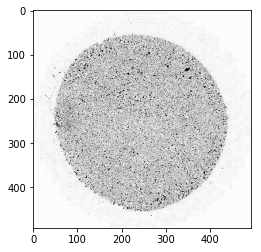

In [24]:
source = np.array(slide.read_region((0, 0), level, slide.level_dimensions[level]).convert('RGB'))
img_gray = cv2.cvtColor(source, cv2.COLOR_RGB2GRAY)
img_gray = cv2.pyrDown(img_gray)
img_gray = cv2.pyrDown(img_gray)

# img_gray = maxpooling(img_gray, kernel_size=3)

# img_gray = cv2.equalizeHist(img_gray)

plt.imshow(img_gray, cmap="gray")

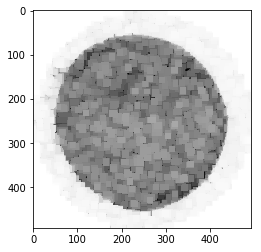

In [25]:
kernel_size = (5, 5)
kernel = np.ones(kernel_size, np.uint8)
img_open = cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, kernel, iterations=3)
# img_open = cv2.morphologyEx(img_open, cv2.MORPH_CLOSE, kernel, iterations=1)
# img_open = cv2.morphologyEx(img_open, cv2.MORPH_ERODE, kernel, iterations=1)
plt.imshow(img_open, cmap="gray")

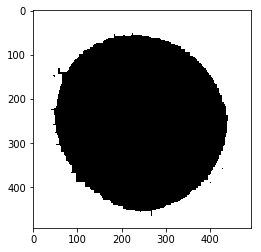

In [26]:
background = img_open > threshold_otsu(img_open) / 0.99
tissue_mask = background.copy()
plt.imshow(tissue_mask, cmap="gray")

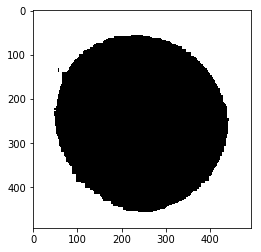

In [27]:
# tissue_mask = tissue_mask * 255
# img_out = maxpooling(tissue_mask, kernel_size=11)
img_out = maxpooling(tissue_mask, kernel_size=(5,1))
img_out = maxpooling(img_out, kernel_size=(1,5))
plt.imshow(img_out, cmap="gray")

In [28]:
img, contours, hierarchy = cv2.findContours(img_out.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
print(len(contours))

3


<class 'numpy.ndarray'> <class 'numpy.ndarray'>


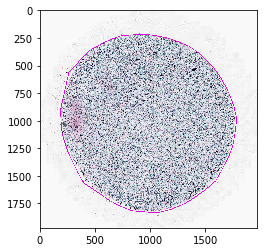

In [29]:
hull = cv2.convexHull(contours[1], False) * 4
print(type(contours[1]), type(hull))

cv2.drawContours(source, [hull], 0, color=(random.randint(0,255),random.randint(0,255),random.randint(0,255)), thickness=5)
plt.imshow(source)

In [30]:
cv2.imwrite("test1.jpg", cv2.cvtColor(source, cv2.COLOR_RGB2BGR))

True

In [31]:
def in_roi_simplified(contour, downsample, x, y, w, h):
    center_x = (x + w / 2) / downsample
    center_y = (y + h / 2) / downsample
    return cv2.pointPolygonTest(contour, (center_x, center_y), False) == 1

def in_roi_completed(contour, downsample, x, y, w, h):
    x /= downsample
    y /= downsample
    w /= downsample
    h /= downsample
    points = [(x, y), (x+w, y), (x+w, y+h), (x, y+h)]
    for point in points:
        if -1 == cv2.pointPolygonTest(contour, point, False):
            return -1
    return 1

In [32]:
m, n = slide.dimensions
print(m, n)

19712 19712


In [33]:
x = 20000
y = 20000
w = 1216
h = 1216
center_x = (x + w / 2) / downsample
center_y = (y + h / 2) / downsample
print(source.shape, center_x, center_y)

in_roi_simplified(hull, downsample, x, y, w, h)

(1971, 1971, 3) 1288.0 1288.0


True

In [16]:
for i in range(0, m, 1216):
    for j in range(0, n, 1216):
        is_in1 = in_roi_simplified(hull, downsample, i, j, 1216, 1216)
        is_in2 = in_roi_completed(hull, downsample, i, j, 1216, 1216)
        print(is_in1, is_in2)

False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
False -1
F

In [17]:
area = cv2.contourArea(hull)
print(area, m*n/downsample/downsample, area*downsample*downsample/m/n)

2157840.0 1526400.0 1.4136792452830187


In [18]:
m, n, _ = source.shape

area = cv2.contourArea(hull)
print(area, m*n, area/m/n)

2157840.0 3907200 0.5522727272727272
